<h1>LSTM for stock price using last 60 days</h1>

#Libraries

In [ ]:
import math

from datetime import date, timedelta,datetime
import time

import numpy as np
import pandas as pd

import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from keras.models import Sequential
from keras.layers import Dense, LSTM

from IPython.display import clear_output

Scaler

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

#Model

Function that returns a fitted LSTM

In [ ]:
def trainModel(train_x,train_y):
    #LSTM 
    model = Sequential()
    model.add(LSTM(50,return_sequences=True, input_shape = (x_train.shape[1],4)))
    model.add(LSTM(50,return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam',loss='mean_squared_error')

    model.fit(x_train,y_train,batch_size=1,epochs=1)

    return model


Function that takes the price of the last 60 days of an asset, and a trained model to return the predicted the price of the next day 

In [ ]:
def predictNextDay(dataframe,model):

    dataframe = dataframe.filter(['Close','High','Low','Open'])
    last_60_days = dataframe[-60:].values
    last_60_days_scaled = scaler.transform(last_60_days)
    x = []
    x.append(last_60_days_scaled)
    x = np.array(x)
    x=np.reshape(x,(x.shape[0],x.shape[1],4))
    pred_price = model.predict(x)

    trainPredict_dataset_like = np.zeros(shape=(len(pred_price), 4) )
    trainPredict_dataset_like[:,0] = pred_price[:,0]
    pred_price = scaler.inverse_transform(trainPredict_dataset_like)[:,0]

    return pred_price



#Backtesting

Ticker and dates

In [ ]:
ticker = str(input("Ticker for Yahoo Finance: "))
date_of_start = str(input("Start date (aaaa-mm-dd) "))
date_of_end = str(input("End date (aaaa-mm-dd): "))

Ticker for Yahoo Finance: ETH-USD
Start date (aaaa-mm-dd) 2020-01-01
End date (aaaa-mm-dd): 2021-05-12


The starting training size of the first date is 60 rows. The model is trained using as labels the prices of the asset, starting 60 days before day 0.  
<br>The features used are: Close price, open price, day high and day low of the 60 days previous to the target. 
<br><br>
For each day (starting 120 days after the start date), this cell:
  - Trains the model using all the data previous to the current date
  - Predicts the price of the next day
  - Appends the actual price and the predicted price to a DataFrame (valid)

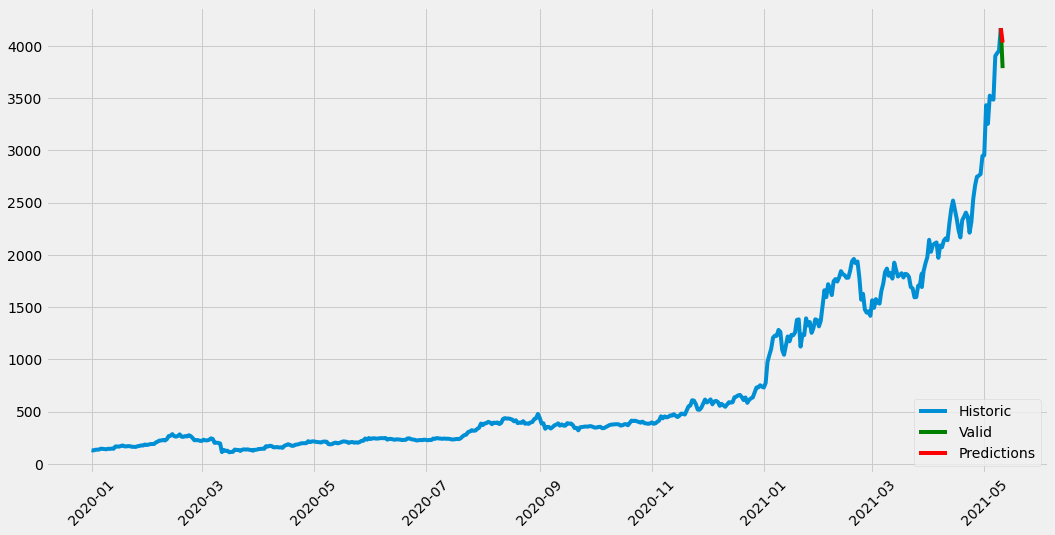

,Real,Pred
Date,,
2020-04-30,214.219101,164.363462
2020-05-01,215.325378,178.297548
2020-05-02,210.933151,204.721948
2020-05-03,208.174011,174.834564
2020-05-04,206.774399,198.852912
...,...,...
2021-05-07,3902.647705,2932.662084
2021-05-08,3928.844727,3482.491173
2021-05-09,3952.293945,3775.032015


In [ ]:
valid = pd.DataFrame(columns=["Date","Real","Pred"])

current_date = date(int(date_of_start.split('-')[0]),int(date_of_start.split('-')[1]),int(date_of_start.split('-')[2])) + timedelta(days=120)

while current_date < date(int(date_of_end.split('-')[0]),int(date_of_end.split('-')[1]),int(date_of_end.split('-')[2])):
  
  #IMPORTING THE DATA FROM YAHOO FINANCE
  df = web.DataReader(ticker,data_source='yahoo',start=date_of_start,end=current_date)
  
  #FILTERING (AVOID TRAINING WITH THE TEST VALUES)
  data = df[0:-1].filter(['Close','High','Low','Open'])
  dataset = data.values

  training_data_len = math.ceil(len(dataset))
  train_data = dataset[0:training_data_len, :]
  
  #SCALING
  train_data = scaler.fit_transform(train_data)

  #CONSTRUCTING THE TRAINING DATA 
  x_train = []
  y_train = []

  for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,:])
    y_train.append(train_data[i,0])

  x_train = np.array(x_train)
  y_train = np.array(y_train)

  x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],4))
  
  #TRAINING THE MODEL AND PREDICTING NEXT DAY
  model = trainModel(x_train,y_train)
  pred = predictNextDay(df,model)


  real_price = df.Close.values[-1]


  #APPENDING TO VALID DATAFRAME
  valid.loc[len(valid)] = ([df.index.values[-1],real_price,pred[0]])


  #PLOTTING
  clear_output()

  plt.figure(figsize=(16,8))
  plt.plot(df.index.values[:-1], df.Close.values[:-1])
  plt.plot([df.index.values[-2],df.index.values[-1]], [df.Close.values[-2],real_price], c='g')
  plt.plot([df.index.values[-2],df.index.values[-1]], [df.Close.values[-2],pred[0]], c='r')
  plt.xticks(rotation=45)
  plt.legend(['Historic','Valid','Predictions'],loc='lower right')
  plt.show()

  #NEXT DAY
  current_date += timedelta(days=1)

valid = valid.set_index("Date")
valid

#Trading strategy

Simple trading strategy to test the LSTM <br>
- If tomorrow's predicted price is superior to to todays close value:
  - Buy the asset with 100% of equity.<br>
  - If there is no equity left: hold. 
<br>
- If tomorrow's predicted price is inferior to todays close value:
  - Sell 100% of the shares<br>
  - If there are no shares left: wait.


In [ ]:
money = 100

decision = []
portfolio = []
stock_qtty = 0
error_log = []
price_df = df
for i, row in valid.iterrows():
  loc = price_df.index.get_loc(i)
  if type(loc) == slice:
    loc = loc.start
  price_day_before = price_df.iloc[loc-1]['Close']

  #buy
  if row.Pred > price_day_before:
    if money == 0:
      decision.append('Hold')
      error_log.append('')
    else:
      decision.append('Buy')
      stock_qtty = money / price_day_before
      money = 0

      if row.Real < price_day_before:
        error_log.append('Bad Buy')
      else:
        error_log.append('')

  #sell
  if row.Pred < price_day_before:
    if money != 0:
      decision.append('Hold')
      error_log.append('')
    else:
      decision.append('Sell')
      money = stock_qtty * price_day_before
      stock_qtty = 0

      if row.Real > price_day_before:
        error_log.append('Bad Sell')
      else:
        error_log.append('')

  if row.Pred == price_day_before:
      decision.append('Hold')


  portfolio.append(money)

backtest = pd.DataFrame(data={'decision':decision,'portfolio':portfolio,'Prediction':valid.Pred,'close':valid.Real,'Error':error_log})
backtest

,decision,portfolio,Prediction,close,Error
Date,,,,,
2020-04-30,Hold,100.000000,164.363462,214.219101,
2020-05-01,Hold,100.000000,178.297548,215.325378,
2020-05-02,Hold,100.000000,204.721948,210.933151,
2020-05-03,Hold,100.000000,174.834564,208.174011,
2020-05-04,Hold,100.000000,198.852912,206.774399,
...,...,...,...,...,...
2021-05-07,Hold,156.822874,2932.662084,3902.647705,
2021-05-08,Hold,156.822874,3482.491173,3928.844727,
2021-05-09,Hold,156.822874,3775.032015,3952.293945,


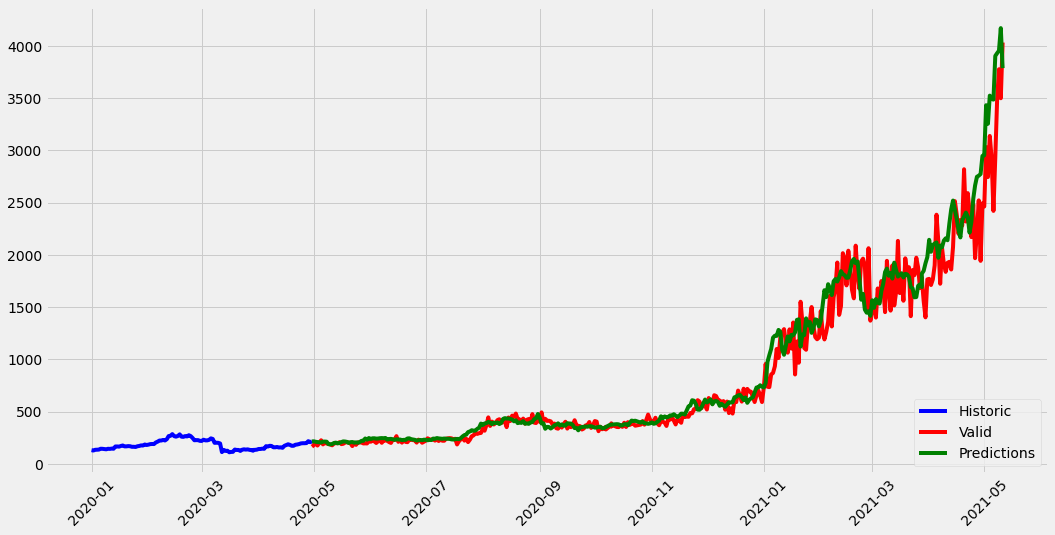

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df[df.index<=valid.index.values[0]].index,df[df.index<=valid.index.values[0]].Close,c='b')
plt.plot(valid.index,valid.Pred,c='r')
plt.plot(valid.index,valid.Real,c='g')
plt.xticks(rotation=45)
plt.legend(['Historic','Valid','Predictions'],loc='lower right')
plt.title("Predictions and actual prices")
plt.ylabel("Asset price USD")
plt.show()

# Portfolio behaviour with trading strategy

In [1]:
plt.scatter(x=backtest[backtest['portfolio']!=0].index, y=backtest[backtest['portfolio']!=0]['portfolio'], color= backtest[backtest['portfolio']!=0]['Error'].apply(lambda x: 'r' if x!='' else 'w') )
plt.plot(backtest[backtest['portfolio']!=0].index,backtest[backtest['portfolio']!=0]['portfolio'])
plt.xticks(rotation=45)
plt.ylabel("Portfolio value")
plt.show() 

NameError: ignored

## Statistics

In [ ]:
print(f"{round(len(backtest[backtest['Error']!=''])*100/len(backtest),2)}% times that algorithm made wrong call")
print(f"Profit: {round((backtest[backtest['portfolio']!=0]['portfolio'][-1] - 100),2)}% in {int((backtest.index.values[-1]-backtest.index.values[0])/np.timedelta64(1,'D'))} days")

backets2 = backtest[backtest['portfolio']!=0].copy()
backets2['average_profit'] = (backets2['portfolio']-backets2['portfolio'].shift(1))*100/backets2['portfolio'].shift(1)

print(f"Average profit: {round(backets2['average_profit'].mean(),2)}%")
print(f"Standard deviation of profit: {round(backets2['average_profit'].std(),2)}")

19.1% times that algorithm made wrong call
Profit: 56.82% in 376 days
Average profit: 0.23%
Standard deviation of profit: 2.96
